# GWAS Tutorial

This tutorial describes how to perform a GWAS with simple linear regression, where each SNP is treated independently when determining its effect on the phenotype. Lets consider our input data to be a genotype matrix $X$ which has $N$ rows (number of individuals) and $M$ columns (number of variants, usually SNPs). We're using [Genotype Representation Graphs](https://grgl.readthedocs.io/en/stable/concepts.html#grg) to represent our genotype matrix. If you have `.vcf.gz` data, see [Converting .vcf.gz to GRG](VCFToGRG.html). If you have (or want) a more efficicient representation than `.vcf.gz` see [Converting IGD to GRG](IGDToGRG.html).

For this tutorial, we'll just use a (really) small simulated dataset of 200 individuals that we can quickly download. Replace it with your own dataset as desired.

The other piece of information we need for performing a GWAS is the phenotype, $Y$. We are just going to simulate a phenotype for this tutorial, but replace it with your own phenotype as desired.

**What you'll need:**
* Python dependencies "grapp", "igdtools", "seaborn": `pip install grapp igdtools seaborn`
* Command line tool "wget": `sudo apt install wget` (or your system's equivalent)

### Get Dataset

In [1]:
%%bash

if [[ ! -e gwas.example.igd ]]; then
  # Download a small example dataset
  wget https://github.com/aprilweilab/grg_pheno_sim/raw/refs/heads/main/demos/data/test-200-samples.vcf.gz -O gwas.example.vcf.gz

  # Convert to IGD; this isn't necessary, but most of the time you will want to do this
  igdtools gwas.example.vcf.gz -o gwas.example.igd
fi

# Just show some stats about the dataset
igdtools -s gwas.example.igd

--2026-02-06 12:38:49--  https://github.com/aprilweilab/grg_pheno_sim/raw/refs/heads/main/demos/data/test-200-samples.vcf.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aprilweilab/grg_pheno_sim/refs/heads/main/demos/data/test-200-samples.vcf.gz [following]
--2026-02-06 12:38:49--  https://raw.githubusercontent.com/aprilweilab/grg_pheno_sim/refs/heads/main/demos/data/test-200-samples.vcf.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494022 (482K) [application/octet-stream]
Saving to: ‘gwas.example.vcf.gz’

     0K .......... .......... .......... .......... .......... 10% 1.99M 0s
    5

Wrote 10893 total variants
Of which 6228 were written sparsely
Stats for gwas.example.igd
... in range 0 - 18446744073709551615
  Variants in range: 10893
  Average samples/var: 50.2075
  Stddev samples/var: 86.1985
  Average var/sample: 1367.28
  Stddev var/sample: 25.9211
  Variants with missing data: 0
  Total missing alleles: 0
  Total unique sites: 10885


## Convert to GRG

In [2]:
%%bash

if [[ ! -e gwas.example.grg ]]; then
  # -j controls how many threads to use.
  grg construct -j 1 gwas.example.igd -o gwas.example.grg
fi

Processing input file in 85 parts.
Auto-calculating number of trees per part.
Converting segments of input data to graphs
100%|██████████| 85/85 [00:00<00:00, 159.81it/s]
Merging...


=== GRG Statistics ===
Nodes: 15481
Edges: 93351
Samples: 400
Mutations: 10893
Ploidy: 2
Phased: true
Populations: 0
Range of mutations: 55829 - 9999127
Specified range: 0 - 10894
Wrote simplified GRG with:
  Nodes: 15481
  Edges: 93351
Wrote GRG to gwas.example.grg


## Simulate Phenotype

Since this phenotype is just for demonstration purposes, we can use the default settings for phenotype simulation. See [Simulating Phenotypes](SimulationPhenotypes.html) for a more detailed tutorial that describes the range of options. Here, we just want a phenotype that has been derived from the genotype: that is, our simulation will choose some "causal mutations" that are responsible for some proportion of the phenotype (this is called the heritability), and compute for each individual a phenotype value from the actual mutations the individual has.

By default, phenotype simulation draws effect sizes for causal SNPs from a standard normal distribution ~$N(0, 1)$.

In [3]:
%%bash

grapp pheno gwas.example.grg

The initial effect sizes are 
       mutation_id  effect_size  causal_mutation_id
0                0    -1.657757                   0
1                1    -0.537562                   0
2                2     1.146189                   0
3                3    -0.697705                   0
4                4    -0.157002                   0
...            ...          ...                 ...
10888        10888    -0.217740                   0
10889        10889     0.936594                   0
10890        10890     0.976964                   0
10891        10891     0.274724                   0
10892        10892     0.711005                   0

[10893 rows x 3 columns]
The genetic values of the individuals are 
     individual_id  genetic_value  causal_mutation_id
0                0     -62.758200                   0
1                1       8.271010                   0
2                2     -93.726026                   0
3                3     -58.657459                   0
4      

## Perform association between genotype and phenotype

Now we want to learn the association between the genotype $X$ and the phenotype $Y$. We are using simple linear regression to do this. The result is a value $\beta_i$ for each mutation $i$: a larger absolute value indicates a larger effect of that mutation (variant) on the phenotype. We are finding *correlations* between $X$ and $Y$. A variant $i$ that is highly correlated with a phenotype $Y$ *might* have a causal relationship to $Y$.

### GWAS via command line

First we'll run the shell commands that perform a GWAS.

In [4]:
%%bash

# Using our phenotype file, emit a tab-separated (tsv) pandas dataframe containing the results of our GWAS between X (test-200-samples.grg) and Y (test-200-samples.grg.phen)
grapp assoc -p gwas.example.grg.phen -o gwas.example.gwas.tsv gwas.example.grg

Wrote results to gwas.example.gwas.tsv


Now we can examine the results by loading the dataframe into pandas.

In [5]:
import pandas

gwas_df = pandas.read_csv("gwas.example.gwas.tsv", delimiter="\t")
gwas_df

,POS,ALT,COUNT,BETA,B0,SE,R2,T,P
0,55829,G,4,0.549634,-0.010993,0.504841,5.950858e-03,1.088726,0.277598
1,56812,T,3,0.907215,-0.013608,0.579622,1.222152e-02,1.565184,0.119137
2,57349,G,1,-0.678575,0.003393,1.003880,2.302321e-03,-0.675952,0.499860
3,58785,T,10,0.057616,-0.002881,0.325235,1.584750e-04,0.177153,0.859570
4,59367,A,2,-0.908389,0.009084,0.709531,8.210244e-03,-1.280268,0.201949
...,...,...,...,...,...,...,...,...,...
10888,9997601,G,3,-0.167107,0.002507,0.583076,4.146596e-04,-0.286595,0.774722
10889,9998038,A,21,0.002723,-0.000286,0.209978,8.491021e-07,0.012966,0.989668
10890,9998412,G,42,0.082101,-0.017241,0.164311,1.259359e-03,0.499667,0.617864
10891,9999031,C,295,-0.095009,0.140138,0.116444,3.350993e-03,-0.815921,0.415526


`BETA` is the effect size for the variant at base-pair position `POS` with alternate allele `ALT`. We can plot the histogram of our inferred `BETA` values and see that it does indeed recover a normal distribution centered at $0$, which is what we simulated with our phenotype.

<Axes: xlabel='BETA', ylabel='Count'>

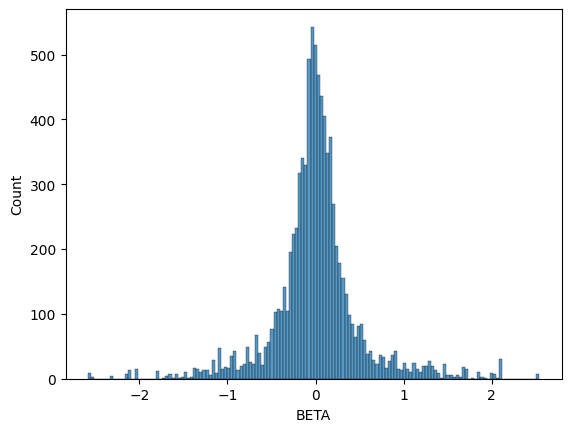

In [6]:
import seaborn
seaborn.histplot(data=gwas_df, x="BETA")

### GWAS via Python APIs

Now we do the same GWAS, but using Python code instead of running `grapp assoc ...` on the command line. This gives us more options. In this example, we'll standardize the genotype matrix $X$ prior to performing the linear regression, which will make all mutations (variants) have the same variance. This has the effect of putting variants with different allele frequencies on the same scale.

In [7]:
from grapp.assoc import linear_assoc_no_covar
import pygrgl

GRG_FILE = "gwas.example.grg"
PHEN_FILE = "gwas.example.grg.phen"

# Load the GRG into memory
grg = pygrgl.load_immutable_grg(GRG_FILE)

# Load the phenotype into memory
Y = pandas.read_csv(PHEN_FILE, delimiter="\t")

# Perform the GWAS
gwas_df = linear_assoc_no_covar(grg, Y["phenotypes"].to_numpy(), standardize=True)
gwas_df

,POS,ALT,COUNT,BETA,B0,SE,R2,T,P
0,55829,G,4,0.076559,-0.001531,0.070680,5.893105e-03,1.083182,0.280045
1,56812,T,3,0.109857,-0.001648,0.070458,1.213189e-02,1.559188,0.120549
2,57349,G,1,-0.047802,0.000239,0.070808,2.296608e-03,-0.675103,0.500398
3,58785,T,10,0.012395,-0.000620,0.070884,1.547976e-04,0.174866,0.861363
4,59367,A,2,-0.090156,0.000902,0.070599,8.169803e-03,-1.277021,0.203090
...,...,...,...,...,...,...,...,...,...
10888,9997601,G,3,-0.020235,0.000304,0.070874,4.116188e-04,-0.285510,0.775552
10889,9998038,A,21,0.000984,-0.000103,0.070889,9.834740e-07,0.013878,0.988941
10890,9998412,G,42,0.035205,-0.007393,0.070843,1.300555e-03,0.496945,0.619779
10891,9999031,C,295,-0.056399,0.083189,0.070528,1.015194e-02,-0.799665,0.424863


We can see that the output format (dataframe) is the same as the command line version. We should expect some differences in the distribution of betas because we standardized $X$ this time, though the shape should still be a normal distribution centered at $0$.

<Axes: xlabel='BETA', ylabel='Count'>

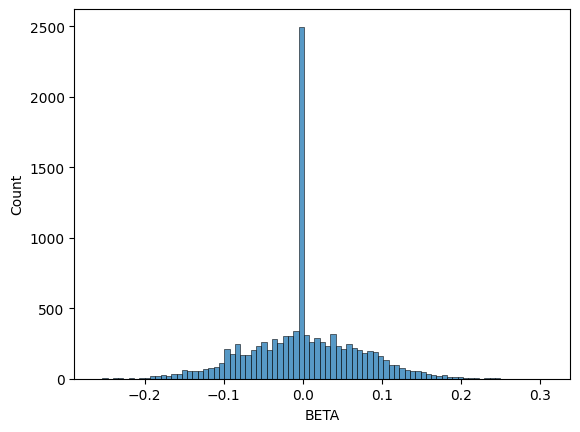

In [8]:
seaborn.histplot(data=gwas_df, x="BETA")

You can see that the range of beta values is much smaller (from $-0.3$ to $+0.3$).

Finally, we can perform one more GWAS where we use an approximate distribution for the variance of each mutation in $X$. Each value in the $X$ matrix can take on a value of $0$, $1$, or $2$, based on how many copies each of the (diploid) individuals has for that allele. By default, the linear regression is performed with the exact sum of squared errors, based on these diploid values in $X$. Theoretically, in the absence of many complicating effects (selection, genotyping error, inbreeding, etc.) the variance of each mutation should follow a binomial distribution with mean $2 \times f_i$ (where $f_i$ is the allele frequency for mutation $i$). You can choose to perform the regression using the binomial distribution, instead of the exact values, via `dist="binomial"`, as shown below.

<Axes: xlabel='BETA', ylabel='Count'>

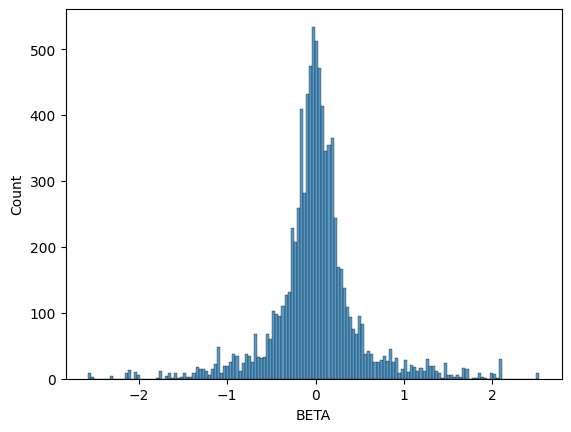

In [9]:
gwas_df = linear_assoc_no_covar(grg, Y["phenotypes"].to_numpy(), dist="binomial")
seaborn.histplot(data=gwas_df, x="BETA")

You can see that this (non-standardized) distribution follows our original (exact) result pretty closely, even with a small sample size of 200 individuals. Partially this is because our genotype matrix $X$ was generated using a neutral simulation; in real datasets, the binomial distribution may cause more beta values to differ from the exact value than is shown here.

## Related Topics

* In practice, GWAS is often performed while handling covariates (such as age, sex, principal components, etc). See [GWAS with Covariates](GWASCovariates.html).
* See [Simulating Phenotypes](SimulationPhenotypes.html) for a more details on generating synthetic phenotypes.
* Documentation links:
  * [grapp.assoc](https://grapp.readthedocs.io/en/latest/grapp.html#module-grapp.assoc): Python APIs for GWAS